Double pendulum motion simulation : Classical Lagrangian Deep Neural network

In [2]:
from __future__ import print_function

import os
import sys
sys.path.append("./sample_data")
#sys.path.append("./model")
#sys.path.append("./dynamics")

from visualize import *
from ode_solver import *
from network import *
from dataloader import *
from lagrangian import *


import numpy as np
import torch
import torch.utils.data

In [37]:
print("--- Loading training and test data... ---")
train_data = np.load('/content/sample_data/train_dataset.npz')
train_inputs = train_data["input"]
train_labels = train_data["labels"]
X_train = train_inputs[:1000]
y_train = train_labels[:1000]

#train_dataset = DynamicsDataset(train_inputs, train_labels)
train_dataset = DynamicsDataset(X_train, y_train)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                                 batch_size=1,
                                                 shuffle=True,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)


test_data = np.load('/content/sample_data/val_dataset.npz')
test_inputs = train_data["input"]
test_labels = train_data["labels"]
#test_dataset = DynamicsDataset(test_inputs, test_labels)
X_test = test_inputs[:1000]
y_test = test_labels[:1000]

test_dataset = DynamicsDataset(X_test, y_test)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 collate_fn=DynamicsDataset.collate_fn,
                                                 pin_memory=True,
                                                 num_workers=1)
print("--- Loading training and test data completed ---")

--- Loading training and test data... ---
--- Loading training and test data completed ---


In [6]:
for (X_train, y_train) in train_dataloader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print('X_train:', X_train)
    print('y_train:', y_train)
    break

for (X_test, y_test) in test_dataloader:
    print('X_test:', X_test.size(), 'type:', X_test.type())
    print('y_test:', y_test.size(), 'type:', y_test.type())
    print('X_test:', X_test)
    print('y_test:', y_test)
    break

./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


X_train: torch.Size([1, 4]) type: torch.DoubleTensor
y_train: torch.Size([1, 4]) type: torch.DoubleTensor
X_train: tensor([[ 2.4841,  1.1141, -0.1981,  0.2497]], dtype=torch.float64)
y_train: tensor([[-0.1981,  0.2497, -5.2559, -7.7180]], dtype=torch.float64)


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


X_test: torch.Size([1, 4]) type: torch.DoubleTensor
y_test: torch.Size([1, 4]) type: torch.DoubleTensor
X_test: tensor([[ 1.9537,  0.2797, -0.0780, -0.2268]], dtype=torch.float64)
y_test: tensor([[-0.0780, -0.2268, -9.3138, -3.6618]], dtype=torch.float64)


In [38]:
# organize data
input_size = train_inputs.shape[1]
output_size = 1  # for all lagrangian systems, output should be just a scalar energy value

# build model
print("--- Constructing Model... ---")
D_in = input_size  # state size
# hidden_list = [D_in, 256, 256, 256, 256, 256]
hidden_list = [D_in, 32, 64, 128, 256, 512, 256, 128, 64, 32]
D_out = output_size
lnn_model = LagrangianNeuralNetwork(D_in, hidden_list, D_out)


# set up training parameters
learning_rate = 1e-4
weight_decay = 1e-5
momentum = 0.9
num_epochs = 20
optimizer = torch.optim.Adam(lnn_model.parameters(),
                              lr=learning_rate,
                              weight_decay=weight_decay)

if os.path.isfile("model_weights.pth"):
    print("Re-loading existing weights!")
    checkpoint = torch.load("model_weights.pth")
    lnn_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

--- Constructing Model... ---
Re-loading existing weights!


In [10]:
# determine device
print("--- Checking for CUDA Device... ---")
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

--- Checking for CUDA Device... ---


In [39]:
import time
# ensure model is in train mode so gradients are properly calculated
lnn_model.train()
# load device to either GPU or CPU depending on hardware
lnn_model.to(device)

# set up loss function
loss_fcn = torch.nn.MSELoss()

# set up GradScaler to improve run speed
scaler = torch.cuda.amp.GradScaler()

print("--- Beginning Training! ---")
loss_list = []
startTimeC = time.time()
print('Training Start Time (in sec) : ',(startTimeC))
print('Training Start Time : ',(time.asctime( time.localtime(time.time()) )))
for epoch in range(num_epochs):
    total_loss = []
    lnn_model.train()
    average_training_loss = 0

    print("Epoch #", epoch)

    for batch_idx, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        for p in lnn_model.parameters(): p.grad = None

        # output from model is the energy calculated from the parameterized lagrangian
        x = torch.squeeze(x)
        with torch.cuda.amp.autocast():
            y_pred = solve_euler_lagrange(lnn_model.forward, x.float())
            loss = loss_fcn(y_pred.unsqueeze(0), y.float())

        # perform backwards pass
        scaler.scale(loss).backward()

        # run optimization step based on backwards pass
        scaler.step(optimizer)

        # update the scale for next iteration
        scaler.update()

        '''
        if batch_idx % 100 == 0:
            print("Iter Num: ", batch_idx)
            print("\t", loss)
        if batch_idx % 5000 == 0:
            print("--- Saving weights ---")
            # save weights after each epoch
            torch.save({
                'epoch': epoch,
                'model_state_dict': lnn_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, "model_weights.pth")
        '''
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / num_epochs, loss_list[-1]))
print('Training End Time (in sec) : ',(time.time()))
print('Total training time (in sec)',((time.time() - startTimeC)))
print('Training End Time',(time.asctime( time.localtime(time.time()) )))
print('end')

--- Beginning Training! ---
Training Start Time (in sec) :  1638408097.5232587
Training Start Time :  Thu Dec  2 01:21:37 2021
Epoch # 0


/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Training [5%]	Loss: 18.7175
Epoch # 1


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [10%]	Loss: 18.0037
Epoch # 2


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [15%]	Loss: 17.0614
Epoch # 3


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [20%]	Loss: 16.1019
Epoch # 4


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [25%]	Loss: 15.3320
Epoch # 5


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [30%]	Loss: 14.2279
Epoch # 6


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [35%]	Loss: 14.0142
Epoch # 7


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [40%]	Loss: 13.7744
Epoch # 8


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [45%]	Loss: 13.5487
Epoch # 9


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [50%]	Loss: 13.2977
Epoch # 10


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [55%]	Loss: 13.2855
Epoch # 11


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [60%]	Loss: 13.1232
Epoch # 12


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [65%]	Loss: 12.5402
Epoch # 13


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [70%]	Loss: 12.2375
Epoch # 14


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [75%]	Loss: 12.2382
Epoch # 15


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [80%]	Loss: 11.9743
Epoch # 16


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [85%]	Loss: 11.9404
Epoch # 17


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [90%]	Loss: 11.6876
Epoch # 18


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [95%]	Loss: 11.6016
Epoch # 19


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)


Training [100%]	Loss: 11.5760
Training End Time (in sec) :  1638409371.790377
Total training time (in sec) 1274.2675168514252
Training End Time Thu Dec  2 01:42:51 2021
end


Text(0, 0.5, 'Loss')

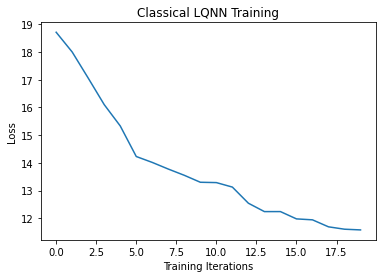

In [40]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title('Classical LQNN Training')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

In [43]:
print("--- Beginning Test! ---")
lnn_model.eval()
total_losstrainC = []
correct = 0
for batch_idx, (data, target) in enumerate(test_dataloader):
    data, target = data.to(device), target.to(device)
    data = torch.squeeze(data)
    with torch.cuda.amp.autocast():
        target_pred = solve_euler_lagrange(lnn_model.forward, data.float())
        #print(target_pred)
        #print(target)
        correct += target_pred.eq(target.view_as(target_pred)).sum().item()
        loss = loss_fcn(target_pred.unsqueeze(0), target.float())        
    total_losstrainC.append(loss.item())
batch_size = 1
print('Performance on test data:[{:.0f}%]\tLoss: {:.4f}\tAccuracy: {:.1f}%'.format(
    100. * (epoch + 1) / num_epochs,
    sum(total_losstrainC) / len(total_losstrainC),
    correct / len(test_dataloader) * 100 / batch_size)
    )

print('end')

--- Beginning Test! ---


./sample_data/dataloader.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_x = torch.as_tensor(batch_x)
/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Performance on test data:[100%]	Loss: 11.2437	Accuracy: 0.0%
end
